# Analysis for Section 5.3

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory
wd = os.path.dirname(os.getcwd())
# relevant folders
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'

In [3]:
# load and modify factual data accordingly (same for all SCFs versions)
org_df = pd.read_csv(data_path + 'clean_LawSchool.csv', sep='|').reset_index(drop=True)
print(org_df.shape)
print(org_df.columns.to_list())
org_df.head(5)

(21790, 7)
['race', 'sex', 'LSAT', 'UGPA', 'ZFYA', 'race_nonwhite', 'race_simpler']


,race,sex,LSAT,UGPA,ZFYA,race_nonwhite,race_simpler
0,White,Female,39.0,3.1,-0.98,White,White
1,White,Female,36.0,3.0,0.09,White,White
2,White,Male,30.0,3.1,-0.35,White,White
3,Hispanic,Male,39.0,2.2,0.58,NonWhite,Latino
4,White,Female,37.0,3.4,-1.26,White,White


In [4]:
# we focus on sex and race_nonwhite
df = org_df[['sex', 'race_nonwhite', 'LSAT', 'UGPA']].copy()
# df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})
# df['race_nonwhite'] = df['race_nonwhite'].map({'White': 0, 'NonWhite': 1})
df.rename(columns={'sex': 'Gender', 'race_nonwhite': 'Race'}, inplace=True)
df.head(5)

,Gender,Race,LSAT,UGPA
0,Female,White,39.0,3.1
1,Female,White,36.0,3.0
2,Male,White,30.0,3.1
3,Male,NonWhite,39.0,2.2
4,Female,White,37.0,3.4


### A 'known' decision maker

We include an *admissions officer* based on [the "known" requirements of US Law Schools](https://schools.lawschoolnumbers.com/). We assume the case for Yale School. We could not find a one-to-one converter between LSAT over 48 to over 180. 173/180 is 96%: it would be about 46.1/48. We assume Yale cuts at these median values, and puts a slightly higher weight on UGPA over LSAT.

In [5]:
# Our decision maker:
b1 = 0.6
b2 = 0.4
min_score = round(b1*3.93 + b2*46.1, 2)  # 20.8
max_score = round(b1*4.00 + b2*48.00)    # 22

In [6]:
# add the decision maker
df['Score'] = b1*df['UGPA'] + b2*df['LSAT']
df['Y'] = np.where(df['Score'] >= min_score, 1, 0)
df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.0,3.1,17.46,0
1,Female,White,36.0,3.0,16.20,0
2,Male,White,30.0,3.1,13.86,0
3,Male,NonWhite,39.0,2.2,16.92,0
4,Female,White,37.0,3.4,16.84,0


### Summary stats

In [7]:
print('Num. of applicants')
print(df.shape[0])
###
print('Females')
print(df[df['Gender'] == 'Female'].shape[0])
print(df[df['Gender'] == 'Female'].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[df['Race'] == 'NonWhite'].shape[0])
print(df[df['Race'] == 'NonWhite'].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)

Num. of applicants
21790
Females
9537
43.76778338687471
Non-whites
3506
16.08994951812758
Female-non-whites
1833
8.41211564938045


In [8]:
print('Num. of accepted applicants')
print(df[df['Y'] == 1].shape[0])
print(df[df['Y'] == 1].shape[0] / df.shape[0] * 100)
###
print('Females')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0] / df.shape[0] * 100)
print('Males')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('Whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('All but female-non-whites')
tot = df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'White')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'NonWhite')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'White')].shape[0]
print(tot)
print(tot / df.shape[0] * 100)


Num. of accepted applicants
505
2.31757687012391
Females
180
0.8260670032124828
Males
325
1.4915098669114273
Non-whites
33
0.15144561725562183
Whites
472
2.166131252868288
Female-non-whites
14
0.06424965580541532
All but female-non-whites
491
2.2533272143184946


### $|\mathbf{A}=1|$: Gender

In [9]:
do = 'Male'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

(21790, 8)
['female', 'nonwhite', 'Sex', 'Race', 'resid_LSAT', 'resid_UGPA', 'scf_LSAT', 'scf_UGPA']


,female,nonwhite,Sex,Race,resid_LSAT,resid_UGPA,scf_LSAT,scf_UGPA
0,0,0,Female,White,1.823899,-0.232222,39.609,2.975
1,0,0,Female,White,-1.176101,-0.332222,36.609,2.875
2,0,0,Male,White,-7.784813,-0.107057,30.000,3.100
3,0,1,Male,NonWhite,5.853746,-0.788069,39.000,2.200
4,0,0,Female,White,-0.176101,0.067778,37.609,3.275


In [10]:
cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
# cf_df['Sex'] = cf_df['Sex'].map({'Male': 0, 'Female': 1})
# cf_df['Race'] = cf_df['Race'].map({'White': 0, 'NonWhite': 1})
cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.609,2.975,17.6286,0
1,Female,White,36.609,2.875,16.3686,0
2,Male,White,30.000,3.100,13.8600,0
3,Male,NonWhite,39.000,2.200,16.9200,0
4,Female,White,37.609,3.275,17.0086,0


Text(0.5, 0, 'LSAT for females')

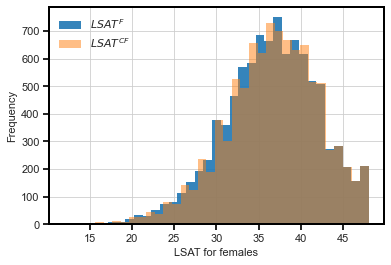

In [18]:
b = 35
plt.hist(df[df['Gender'] == 'Female']['LSAT'], bins=b, alpha=0.9, label=r'$LSAT^F$')
plt.hist(cf_df[cf_df['Gender'] == 'Female']['LSAT'], bins=b, alpha=0.5, label=r'$LSAT^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'LSAT for females')

Text(0.5, 0, 'UGPA for females')

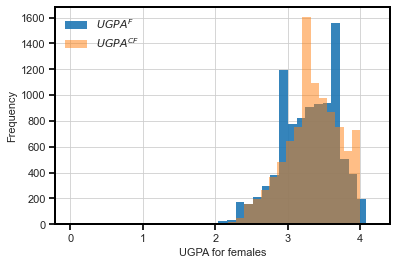

In [28]:
b = 35
plt.hist(df[df['Gender'] == 'Female']['UGPA'], bins=b, alpha=0.9, label=r'$UGPA^F$')
plt.hist(cf_df[cf_df['Gender'] == 'Female']['UGPA'], bins=b, alpha=0.5, label=r'$UGPA^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'UGPA for females')

In [ ]:
# store do:=Male results
m_res_df = df[['Gender', 'Race', 'Y']].copy()
m_res_df['cf_Y'] = cf_df[['Y']].copy()
m_res_df.head(5)

In [ ]:
print(df[(df['Gender'] == 'Female') & (df['Y']==1)].shape[0] / df[df['Gender'] == 'Female'].shape[0] * 100)
print(df[(df['Gender'] == 'Male') & (df['Y']==1)].shape[0] / df[df['Gender'] == 'Male'].shape[0] * 100)

print(df[(df['Race'] == 'NonWhite') & (df['Y']==1)].shape[0] / df[df['Race'] == 'NonWhite'].shape[0] * 100)
print(df[(df['Race'] == 'White') & (df['Y']==1)].shape[0] / df[df['Race'] == 'White'].shape[0] * 100)

In [ ]:
# --- attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'Male', 'protected': 'Female'}

# --- st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

Notice that, by construction, by not specifying 'Race' (or 'Gender') as a relevant feature, ST will ignore it.

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['stST'] < tau)].shape[0]

#### Counterfactual Situation Testing (cfST)

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
m_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
m_res_df[m_res_df['CF'] == 1].shape[0]

In [ ]:
# positive discrimination?
m_res_df[m_res_df['CF'] == 2].shape[0] 

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])

m_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                include_centers=True,
                                k=n, alpha=alpha, tau=tau)

In [ ]:
m_res_df[(m_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
m_res_df[(m_res_df['cfST_w'] < tau)].shape[0]

### Add CIs for CF

In [ ]:
df_wcf_sf_disc = wcf_st.get_test_discrimination()
df_wcf_sf_disc.head(5)

In [ ]:
# add this to results to showcase the method
df_wcf_sf_disc[df_wcf_sf_disc['individual'].isin(m_res_df[m_res_df['CF'] == True].index.to_list())].head(5)

### $|\mathbf{A}=1|$: Race

In [20]:
do = 'White'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

(21790, 8)
['female', 'nonwhite', 'Sex', 'Race', 'resid_LSAT', 'resid_UGPA', 'scf_LSAT', 'scf_UGPA']


,female,nonwhite,Sex,Race,resid_LSAT,resid_UGPA,scf_LSAT,scf_UGPA
0,1,0,Female,White,1.823899,-0.232222,39.000,3.100
1,1,0,Female,White,-1.176101,-0.332222,36.000,3.000
2,0,0,Male,White,-7.784813,-0.107057,30.000,3.100
3,0,0,Male,NonWhite,5.853746,-0.788069,43.639,2.419
4,1,0,Female,White,-0.176101,0.067778,37.000,3.400


In [21]:
cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
cf_df = cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.000,3.100,17.460,0
1,Female,White,36.000,3.000,16.200,0
2,Male,White,30.000,3.100,13.860,0
3,Male,NonWhite,43.639,2.419,18.907,0
4,Female,White,37.000,3.400,16.840,0


Text(0.5, 0, 'LSAT for non-whites')

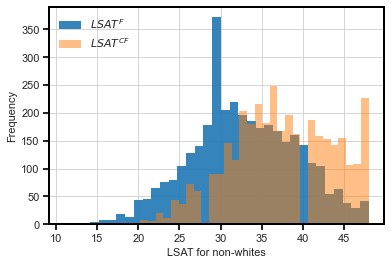

In [26]:
b = 35
plt.hist(df[df['Race'] == 'NonWhite']['LSAT'], bins=b, alpha=0.9, label=r'$LSAT^F$')
plt.hist(cf_df[cf_df['Race'] == 'NonWhite']['LSAT'], bins=b, alpha=0.5, label=r'$LSAT^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'LSAT for non-whites')

Text(0.5, 0, 'UGPA for non-whites')

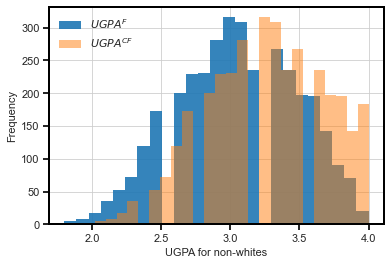

In [25]:
b = 25
plt.hist(df[df['Race'] == 'NonWhite']['UGPA'], bins=b, alpha=0.9, label=r'$UGPA^F$')
plt.hist(cf_df[cf_df['Race'] == 'NonWhite']['UGPA'], bins=b, alpha=0.5, label=r'$UGPA^{CF}$')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel(r'UGPA for non-whites')

In [ ]:
# df.groupby(['Y', 'Race']).count()
# cf_df.groupby(['Y', 'Race']).count()

In [ ]:
# store do:=White results
w_res_df = df[['Gender', 'Race', 'Y']].copy()
w_res_df['cf_Y'] = cf_df[['Y']].copy()
w_res_df.head(5)

In [ ]:
# attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'Race'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 'White', 'protected': 'NonWhite'}

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

Notice that, by construction, by not specifying 'Race' (or 'Gender') as a relevant feature, ST will ignore it.

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,  
                          sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                          k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['stST'] < tau)].shape[0]

#### Counterfactual Situation Testing (cfST)

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                             sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                             include_centers=False,
                             k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
w_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
w_res_df[w_res_df['CF'] == 1].shape[0]

In [ ]:
w_res_df[w_res_df['CF'] == 2].shape[0]

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

w_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                include_centers=True,
                                k=n, alpha=alpha, tau=tau)

In [ ]:
w_res_df[(w_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
w_res_df[(w_res_df['cfST_w'] < tau)].shape[0]

### Multiple discrimination: $|\mathbf{A}|=2$

In [ ]:
df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0]

In [ ]:
# for stST
pd.merge(left=m_res_df[m_res_df['stST'] > tau], right=w_res_df[w_res_df['stST'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST +
pd.merge(left=m_res_df[m_res_df['stST'] < tau], right=w_res_df[w_res_df['stST'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for cfST
pd.merge(left=m_res_df[m_res_df['cfST'] > tau], right=w_res_df[w_res_df['cfST'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for cfST +
pd.merge(left=m_res_df[m_res_df['cfST'] < tau], right=w_res_df[w_res_df['cfST'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST_w
pd.merge(left=m_res_df[m_res_df['cfST_w'] > tau], right=w_res_df[w_res_df['cfST_w'] > tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for stST_w +
pd.merge(left=m_res_df[m_res_df['cfST_w'] < tau], right=w_res_df[w_res_df['cfST_w'] < tau], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for Counterfactual Fairness
pd.merge(left=m_res_df[m_res_df['CF'] == 1], right=w_res_df[w_res_df['CF'] == 1], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

In [ ]:
# for Counterfactual Fairness w +
pd.merge(left=m_res_df[m_res_df['CF'] == 2], right=w_res_df[w_res_df['CF'] == 2], 
         how='inner', 
         left_index=True, right_index=True).shape[0]

### Intersectional Discrimination: $A_1 \cap A_2$

In [ ]:
do = 'MaleWhite'
org_cf_df = pd.read_csv(data_path + '\\counterfactuals\\' + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
print(org_cf_df.shape)
print(org_cf_df.columns.to_list())
org_cf_df.head(5)

In [ ]:
cf_df = org_cf_df[['GenderRace', 'scf_LSAT', 'scf_UGPA']].copy()
cf_df = cf_df.rename(columns={'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})

# add the decision maker
cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
cf_df.head(5)

In [ ]:
# add the intersectional var to df
df.head()
df['GenderRace'] =  df['Gender'] + '-' + df['Race']
df.head(5)

In [ ]:
# df.groupby(['Y', 'GenderRace']).count()
# cf_df.groupby(['Y', 'GenderRace']).count()

In [ ]:
# store do:=White results
int_res_df = df[['Gender', 'Race', 'Y']].copy()
int_res_df['cf_Y'] = cf_df[['Y']].copy()
int_res_df.head(5)

In [ ]:
# attribute-specific params
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
# list of relevant features
feat_rlvt = ['LSAT', 'UGPA']
# protected feature
feat_prot = 'GenderRace'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': ['Female-White', 'Male-NonWhite', 'Male-NonWhite', 'Male-White'], 
                  'protected': 'Female-NonWhite'
                 }

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

#### Standard ST (stST)

In [ ]:
test_df = df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['GenderRace'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals,
                            sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                            k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['stST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['stST'] < tau)].shape[0]

#### Counterfactual Situation Testing (cfST)

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['cfST'] = cf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                               sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                               include_centers=False,
                               k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['cfST'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['cfST'] < tau)].shape[0]

#### Counterfactual Fairness

In [ ]:
int_res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
int_res_df[int_res_df['CF'] == 1].shape[0]

In [ ]:
int_res_df[int_res_df['CF'] == 2].shape[0]

#### cfST with centers

In [ ]:
test_df    = df.copy()
test_cf_df = cf_df.copy()

# include the centers
wcf_st = SituationTesting()
wcf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])

int_res_df['cfST_w'] = wcf_st.run(target_att=feat_trgt, target_val=feat_trgt_vals, 
                                  sensitive_att=feat_prot, sensitive_val=feat_prot_vals,
                                  include_centers=True,
                                  k=n, alpha=alpha, tau=tau)

In [ ]:
int_res_df[(int_res_df['cfST_w'] > tau)].shape[0]

In [ ]:
# positive discrimination?
int_res_df[(int_res_df['cfST_w'] < tau)].shape[0]